<a href="https://colab.research.google.com/github/raz0208/Advance-Quantitative-Research-Project/blob/main/Task4/Strategic_Bucketing_of_FICO_Scores_for_PD_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 4: Bucket FICO scores**
# **Strategic Bucketing of FICO Scores for PD Modeling**
### Data-Driven Bucketing of Credit Scores Using MSE and Log-Likelihood Optimization

## **Step 1: Load And Read Dataset**


In [20]:
# Import Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [21]:
# Load And Read Dateset
df = pd.read_csv('/content/Task 3 and 4_Loan_Data.csv')
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [23]:
# Create new dataframe with "fico_score" and "default"
fs_df = df[['fico_score', 'default']]
fs_df = fs_df.sort_values(by='fico_score').reset_index(drop=True) # Sort fs_df by "fisco_score"

fs_df.head()

,fico_score,default
0,408,0
1,409,1
2,418,1
3,425,1
4,438,1


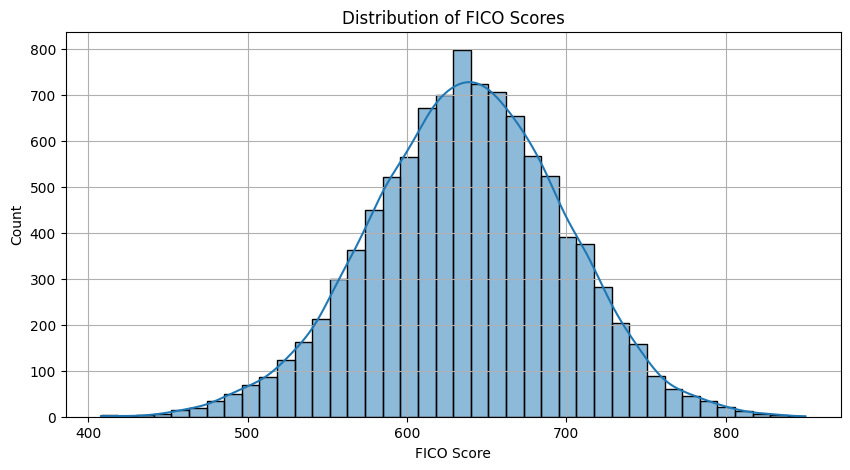

In [24]:
# Distribution of FICO scores plot
plt.figure(figsize=(10, 5))
sns.histplot(x='fico_score', data=fs_df, bins=40, palette='viridis', kde=True)
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Overall Default Rate: 18.51% 



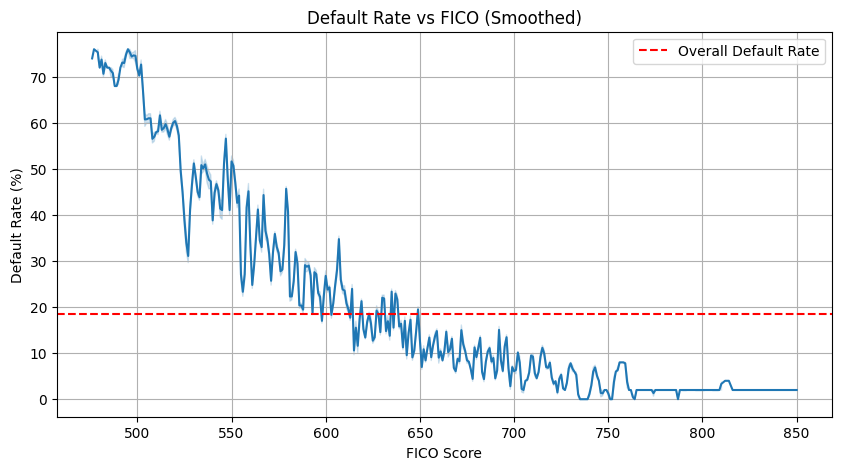

In [25]:
# Default rate overall and by FICO range
default_rate = fs_df['default'].mean() * 100
print(f'Overall Default Rate: {default_rate:.2f}%', "\n")

# calculate rollong pd
window = 50
fs_df['rolling_pd'] = fs_df['default'].rolling(window=window).mean() * 100
mask = fs_df['rolling_pd'] > 100
fs_df.loc[mask, 'rolling_pd'] = 100

# Default Rate vs FICO (Smoothed)
plt.figure(figsize=(10, 5))
sns.lineplot(x='fico_score', y='rolling_pd', data=fs_df)
plt.axhline(y=default_rate, color='red', linestyle='--', label='Overall Default Rate')
plt.title('Default Rate vs FICO (Smoothed)')
plt.xlabel('FICO Score')
plt.ylabel('Default Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

## **Preprocess Data**
We first group the data by unique FICO scores. This turns the problem from processing 10,000 rows to processing ~450 unique score points, making the algorithm extremely fast.

In [39]:
# Group by FICO score to summarize data (Optimization step)
# This reduces the complexity from N=10,000 to N=~450
df_grouped = df.groupby('fico_score')['default'].agg(['sum', 'count']).sort_index()
df_grouped.columns = ['defaults', 'total']

fico_scores = df_grouped.index.values
defaults = df_grouped['defaults'].values
totals = df_grouped['total'].values
n_unique = len(fico_scores)

# Precompute cumulative sums for O(1) access to bucket stats
cum_defaults = np.concatenate(([0], np.cumsum(defaults)))
cum_totals = np.concatenate(([0], np.cumsum(totals)))

## **Define Log-Likelihood Bucket Cost**

In [40]:
# Define Log-Likelihood Function
def calculate_ll_cost(d, t):
    """
    Calculates Log-Likelihood for a single bucket with d defaults and t total.
    LL = k * ln(p) + (n-k) * ln(1-p)
    """
    if t == 0: return 0
    p = d / t
    # Handle edge cases where p=0 or p=1 to avoid log(0)
    term1 = d * np.log(p) if d > 0 and p > 0 else 0
    term2 = (t - d) * np.log(1 - p) if (t - d) > 0 and (1 - p) > 0 else 0
    return term1 + term2

## **Dynamic Programming optimization**
We use a DP algorithm to find the optimal cut points for any given $K$. The state dp[k][i] represents the maximum log-likelihood achievable by splitting the first $i$ scores into $k$ buckets.

In [41]:
# Dynamic Programming Algorithm
max_K = 20  # Maximum buckets to test
dp = np.full((max_K + 1, n_unique + 1), -np.inf)
path = np.zeros((max_K + 1, n_unique + 1), dtype=int)

# Base case: 1 bucket
for i in range(1, n_unique + 1):
    d = cum_defaults[i] - cum_defaults[0]
    t = cum_totals[i] - cum_totals[0]
    dp[1][i] = calculate_ll_cost(d, t)

# Iterate for k = 2 to max_K
for k in range(2, max_K + 1):
    for i in range(k, n_unique + 1):
        # Find best split point j (between k-1 and i)
        # We search for j that maximizes: dp[k-1][j] + LL(bucket from j to i)

        # Optimization: We can restrict search space or just loop.
        # Given n_unique ~450, a simple loop is fast enough (~1-2s).
        best_val = -np.inf
        best_j = -1

        for j in range(k-1, i):
            d = cum_defaults[i] - cum_defaults[j]
            t = cum_totals[i] - cum_totals[j]
            val = dp[k-1][j] + calculate_ll_cost(d, t)

            if val > best_val:
                best_val = val
                best_j = j

        dp[k][i] = best_val
        path[k][i] = best_j

## **Analyze the result and Visualization**

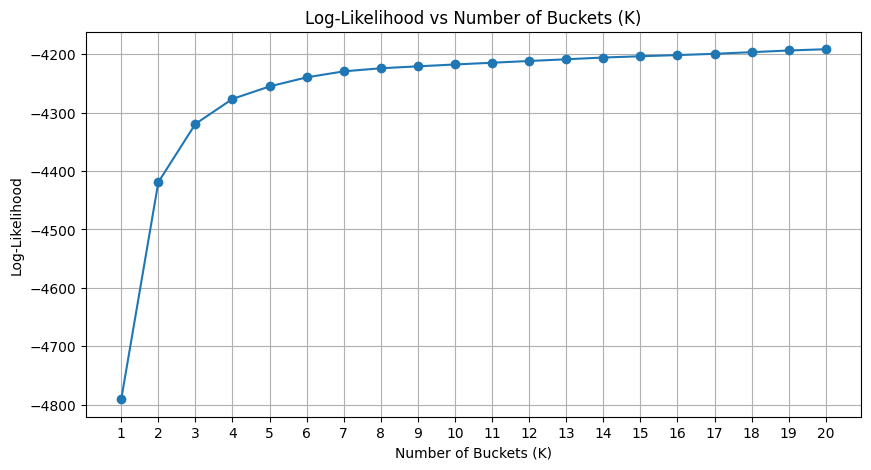

In [42]:
# Analyze Results to Select Best K
results = []
for k in range(1, max_K + 1):
    results.append({'k': k, 'll': dp[k][n_unique]})

res_df = pd.DataFrame(results)
res_df['improvement'] = res_df['ll'].diff()

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(res_df['k'], res_df['ll'], marker='o')
plt.title('Log-Likelihood vs Number of Buckets (K)')
plt.xlabel('Number of Buckets (K)')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.xticks(range(1, max_K + 1))
plt.show()

### **Automatic Selection of Optimal K**
Elbow Method: To select the "Best K", the code iterates from $K=1$ to $20$, calculates the Log-Likelihood for each, and plots the curve. The optimal $K$ is chosen where the marginal gain in likelihood (the "improvement") diminishes significantly (the "elbow").

In [43]:
# Choose K where improvement drops below a threshold
threshold = 5  # This threshold can be tuned (e.g., based on AIC/BIC or simple slope)
best_k = res_df[res_df['improvement'] < threshold].iloc[0]['k'] - 1
if np.isnan(best_k): best_k = max_K # Fallback

print(f"Suggested Optimal K (Elbow Point): {best_k}")

Suggested Optimal K (Elbow Point): 8.0


## **Recover Optimal Bucket Boundaries**

In [44]:
# Extract Boundaries for Best K
def get_boundaries(k, n_idx, path_matrix, scores):
    boundaries = []
    curr = n_idx
    # Make sure K is intiger
    k = int(k)
    # We trace back from the last bucket to the first
    for step in range(k, 1, -1):
        prev = path_matrix[step][curr]
        boundaries.append(scores[prev])
        curr = prev
    return sorted(boundaries)

best_boundaries = get_boundaries(best_k, n_unique, path, fico_scores)
print(f"Optimal Boundaries for K={best_k}: {best_boundaries}")

Optimal Boundaries for K=8.0: [np.int64(521), np.int64(553), np.int64(581), np.int64(612), np.int64(650), np.int64(697), np.int64(733)]


##  **Apply to Data and Visualize**


Bucket Statistics:
   fico_bucket  min_fico  max_fico  default_rate  count
0            0       408       521      0.651899    316
1            1       522       553      0.454000    500
2            2       554       581      0.330159    945
3            3       582       612      0.241619   1581
4            4       613       650      0.161460   2465
5            5       651       697      0.096488   2591
6            6       698       733      0.058934   1069
7            7       734       850      0.024390    533 



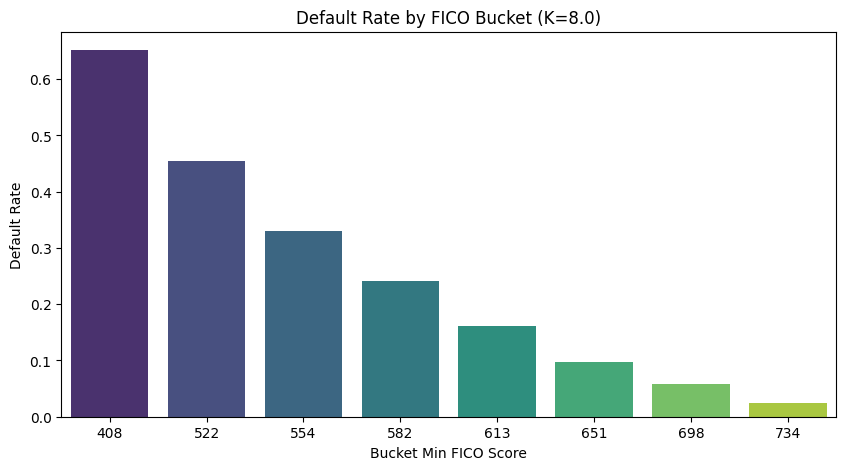

In [45]:
# Create buckets
df['fico_bucket'] = pd.cut(df['fico_score'], bins=[-np.inf] + best_boundaries + [np.inf], labels=False)
bucket_stats = df.groupby('fico_bucket').agg(
    min_fico=('fico_score', 'min'),
    max_fico=('fico_score', 'max'),
    default_rate=('default', 'mean'),
    count=('default', 'count')
).reset_index()

print("\nBucket Statistics:")
print(bucket_stats, "\n")

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='min_fico', y='default_rate', data=bucket_stats, palette='viridis')
plt.title(f'Default Rate by FICO Bucket (K={best_k})')
plt.xlabel('Bucket Min FICO Score')
plt.ylabel('Default Rate')
plt.show()